# Acute Lymphoblastic Leukemia 

Leukemia is a type of cancer that affects the blood and bone marrow. This causes the body to producee too much adnormal white blood cells. These cells cannot fight infections and prevent bone marrow from poducing healthy red blood cells and platelets. 

Acute lymphoblastic leukemia is one of the most common type of childhood cancers, totaling up to 25% of pediatric cancers. Identifying leukemic cells from normal cells nuder the microscope can be challenging becuase of the morphological similarities.


**Task:** Using image classification model, identify normal cells from cancer cells. 

**Data Source:** https://www.kaggle.com/datasets/andrewmvd/leukemia-classification

In [1]:
import numpy as np
import pandas as pd
import random


# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D

# sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from imblearn.under_sampling import RandomUnderSampler

import seaborn as sns
import matplotlib.pyplot as plt

import os
import zipfile

TRAIN_DATA_PATH = "./C-NMC_Leukemia/training_data"
VAL_DATA_PATH = "./C-NMC_Leukemia/validation_data"


## Downloading Data
* combining training and validation set because kaggle does not provide the labels for the test set. 
* After combining, will split the data into train, test, and validation

In [29]:
# Downloading Data
'''
archive = zipfile.ZipFile('archive.zip', 'r')

# training 
for file in archive.namelist():
    if file.startswith('C-NMC_Leukemia/training_data/'):
        archive.extract(file, './')
# validation
for file in archive.namelist():
    if file.startswith('C-NMC_Leukemia/validation_data'):
        archive.extract(file, './')
'''


"\narchive = zipfile.ZipFile('archive.zip', 'r')\n\n# training \nfor file in archive.namelist():\n    if file.startswith('C-NMC_Leukemia/training_data/'):\n        archive.extract(file, './')\n# validation\nfor file in archive.namelist():\n    if file.startswith('C-NMC_Leukemia/validation_data'):\n        archive.extract(file, './')\n"

In [2]:
def load_data(path_to_data,data_type, target_size=(224, 224) ):
    '''Load 2D images and their corresponding labels
    Parameters:
    path_to_data (str): This is the path to data
    data_type (str): This tells us the type of dataset in path_to_data
    target_size (int,int): target size of images

    Returns:
    images (np.ndarray): A numpy array of shape (N, 224, 224, 3)
    labels (np.ndarray): A numpy array of shape (N)
    
    '''
    # also resizing images to help with reducing computational load
    # without resizing, takes up too much memory
    images = []
    labels = []

    l = os.listdir(path_to_data)

    # Training data
    if data_type == 'train':
        for fold in l:
            fold_path = os.path.join(path_to_data, fold)

            for label in os.listdir(fold_path):
                label_path = os.path.join(fold_path, label)

                image_file = os.listdir(label_path)
                for image in image_file:
                    image_path = os.path.join(label_path,image,)
                    img = load_img(image_path, color_mode="rgb", target_size = target_size)
                    images.append(img)
                    labels.append(label)
        labels = [1 if i == 'all' else  0 for i in labels]
        
    # Validation 
    if data_type == 'val':
        for val in l:
            if val == 'C-NMC_test_prelim_phase_data':
                val_path = os.path.join(path_to_data, val)
                image_file = os.listdir(val_path)
                for image in image_file:
                    image_path = os.path.join(val_path,image)
                    img = load_img(image_path, color_mode="rgb", target_size = target_size)
                    images.append(img)
            else:
                filename = path_to_data+ "/"+ val
                print(filename)
                df = pd.read_csv(filename)
                labels = df['labels'].to_list()
    
    images = np.array(images)
    labels = np.array(labels)

    return images, labels


In [3]:
# Leukemia Data
images1, labels1 = load_data(TRAIN_DATA_PATH, "train")
images2, labels2 = load_data(VAL_DATA_PATH, "val")

images = np.concatenate((images1,images2), axis = 0)
labels = np.concatenate((labels1,labels2), axis = 0)

./C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv


## Exploratory Data Analysis 
1 = cancer, 0 = normal cell 

Text(0, 0.5, 'Frequency')

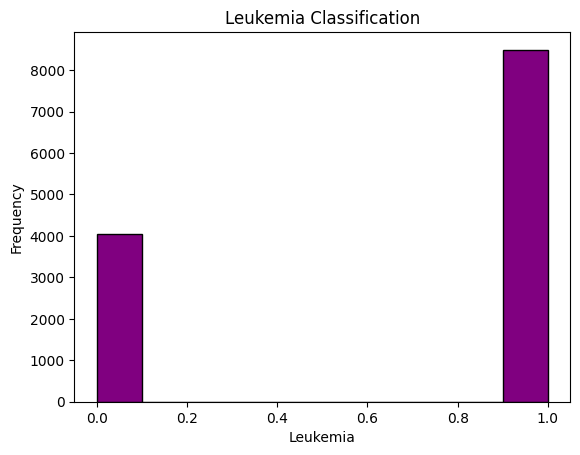

In [4]:
# How many cancer cells are there in the dataset?
# all = cancer, hem = normal cell  
plt.hist(labels, color = 'purple', edgecolor = 'black')
plt.title("Leukemia Classification")
plt.xlabel("Leukemia")
plt.ylabel("Frequency")

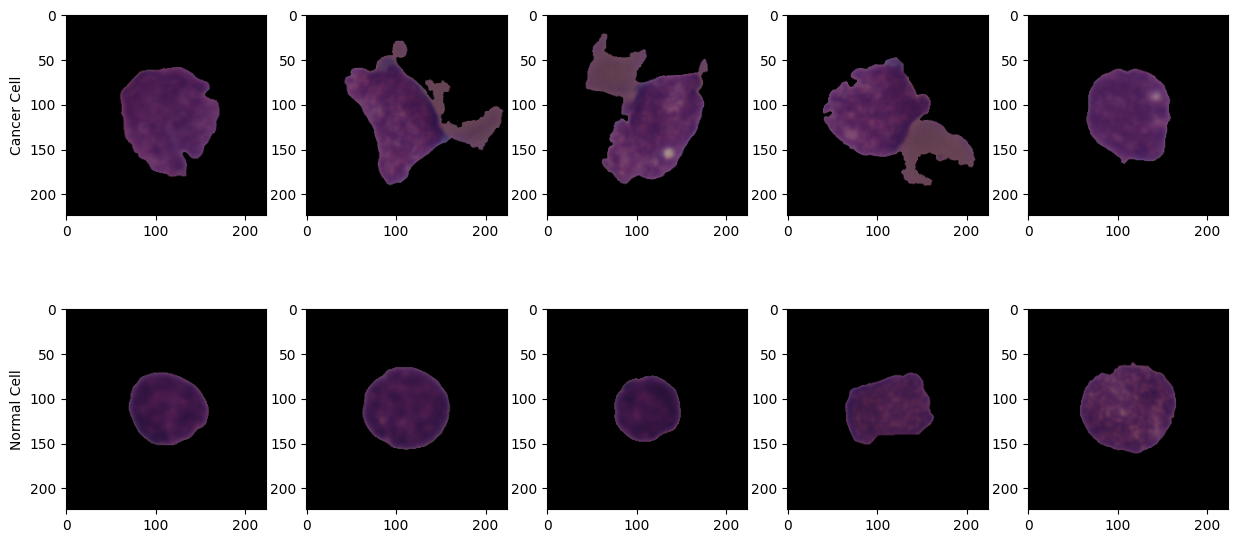

In [5]:
# First 5 images for each class 

label_names = [1, 0]
class_leukemia = {i: [] for i in label_names}
for  index, value in enumerate(labels):
    if len(class_leukemia[value]) < 5:
        class_leukemia[value].append(images[index])
    if all(len(images) == 5 for images in class_leukemia.values()):
        break

# ploting 5 images per class
fig, axes = plt.subplots(2,5, figsize = (15, 7))
for label_index in range(len(label_names)):
    for image_index in range(5):
        ax = axes[label_index, image_index]
        ax.imshow(class_leukemia[label_names[label_index]][image_index])
        if image_index == 0:
            if label_names[label_index] == 1:
                ax.set_ylabel("Cancer Cell")
            else:
                ax.set_ylabel("Normal Cell")



## Data preprocessing 
From the histogram we can see there is an imbalance in labels. There are more cancer cells than normal cells. '
https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/


Text(0, 0.5, 'Frequency')

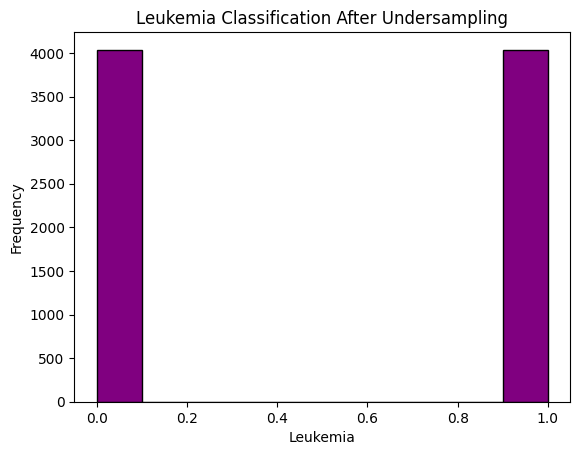

In [6]:
## Undersampling majority and Normalizing 

# rescaling data by dividing each pixal by 255.0
images = images.astype('float32') / 255.0
# reshaping numpy array
num_samples, height, width, channels = images.shape
images_reshaped = images.reshape(num_samples, -1)
# applying undersampling
undersample = RandomUnderSampler(sampling_strategy='majority')
images_mini, labels_mini = undersample.fit_resample(images_reshaped, labels)


plt.hist(labels_mini, color = 'purple', edgecolor = 'black')
plt.title("Leukemia Classification After Undersampling")
plt.xlabel("Leukemia")
plt.ylabel("Frequency")


## Split Data into Train, Test, Validation

To do:
* random flip of images, 

In [7]:
def splitting_data(images, labels, splits):
    """ Split data into train, validation, and test set 
    Params:
    -------
    images (np.ndarray): Images of shape ...
    labels (np.ndarray): Labels of shape(N, )
    """
    np.random.seed(1234)

    # shuffle data
    indices = np.arange(len(labels))
    np.random.shuffle(indices)
    images = images[indices]
    labels = labels[indices]

    # create data splits (training, val, test)
    X_train, X_temp, y_train, Y_temp = train_test_split(images, labels, test_size = (1 - splits[0]), random_state = 1234)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, Y_temp, test_size=splits[2]/(splits[1]+splits[2]), random_state=1234)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [8]:
split = (0.6, 0.2, 0.2)

X_train, y_train, X_val, y_val, X_test, y_test = splitting_data(images_mini,labels_mini,split)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (4844, 150528)
y_train shape (4844,)
X_val shape (1615, 150528)
y_val shape (1615,)
X_test shape (1615, 150528)
y_test shape (1615,)
